# Import Data

In [1]:
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc, plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt

from sklearn.preprocessing import label_binarize


from sklearn.decomposition import PCA

In [2]:
import seaborn as sns
sns.set()

In [3]:
def create_confusion_matrix(y_true, y_pred, labels=None, sample_weight=None, normalize=None, display_labels=None,
                           include_values=True, xticks_rotation='horizontal', values_format=None,
                           cmap='viridis', ax=None, colorbar=True):
    
    cm = confusion_matrix(y_true, y_pred, normalize=normalize)
    
    if display_labels is None:
        if labels is None:
            display_labels = unique_labels(y_true, y_pred)
        else:
            display_labels = labels

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=display_labels)
    return disp.plot(include_values=include_values,
                     cmap=cmap, ax=ax, xticks_rotation=xticks_rotation,
                     values_format=values_format)

In [4]:
def specificity_score(y_true, y_pred):
    TN = 0
    FP = 0
    for i in range(len(y_pred)):
        if y_pred[i] == 0 and y_true[i] == 0:
            TN += 1
        if y_pred[i] == 1 and y_true[i] == 0:
            FP += 1
    
    return TN / (TN + FP)

In [5]:
def positive_pv_score(y_true, y_pred):
    TP = 0
    FP = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i] == 1:
            TP += 1
        elif y_true[i] == 0 and y_pred[i] == 1:
            FP += 1

    return TP/(TP+FP)

In [6]:
def negative_pv_score(y_true, y_pred): ##
    TN = 0
    FN = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i] == 0:
            TN += 1
        elif y_true[i] == 1 and y_pred[i] == 0:
            FN += 1
    
    return TN/(TN+FN) 

In [7]:
def create_ci(bootstrapped_scores, name): ##
    for i in range(3):
        sorted_scores = np.array(bootstrapped_scores)[:, i]
        sorted_scores.sort()
    
        confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
        confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
    
        print("95% Confidence interval for the {} score for class {}: [{:0.4f} - {:0.4}]".format(name, i,
        confidence_lower, confidence_upper))

In [8]:
def my_classification_report(y_test_np, y_pred):

    tot_TN = 0
    tot_TP = 0
    tot_FP = 0
    tot_FN = 0

    spec_arr = []
    ppv_arr = [] ##
    npv_arr = [] ##
    rec_arr = []
    acc_arr = []

    print("Specificities")
    for group in range(3):
        TN = 0
        TP = 0 ##
        FN = 0 ##
        FP = 0
        for i in range(len(y_test_np)):
            if y_pred[i] != group and y_test_np[i] != group:
                TN += 1
            if y_pred[i] == group and y_test_np[i] != group:
                FP += 1
        tot_TN += TN
        tot_FP += FP
        spec_arr.append(TN/(TN+FP))
        print(group, spec_arr[group])

    print("Macro Avg : " + str(np.array(spec_arr).mean()))
    print("Micro Avg : " + str(tot_TN / (tot_TN + tot_FP)), '\n') ##

    tot_TN = 0
    tot_TP = 0
    tot_FP = 0
    tot_FN = 0

    print("PPV/Precision") ##
    for group in range(3):
        TN = 0
        TP = 0 ##
        FN = 0 ##
        FP = 0
        for i in range(len(y_test_np)):
            if y_pred[i] == group and y_test_np[i] == group:
                TP += 1
            if y_pred[i] == group and y_test_np[i] != group:
                FP += 1
        tot_TP += TP
        tot_FP += FP
        ppv_arr.append(TP/(TP+FP))
        print(group, ppv_arr[group])
    
    print("Macro Avg : " + str(np.array(ppv_arr).mean()))
    prec_for_mic_f1 = tot_TP / (tot_TP + tot_FP)
    print("Micro Avg : " + str(prec_for_mic_f1), '\n')

    tot_TN = 0
    tot_TP = 0
    tot_FP = 0
    tot_FN = 0

    print("NPV") ##
    for group in range(3):
        TN = 0
        TP = 0 ##
        FN = 0 ##
        FP = 0
        for i in range(len(y_test_np)):
            if y_pred[i] != group and y_test_np[i] != group:
                TN += 1
            if y_pred[i] != group and y_test_np[i] == group:
                FN += 1
        tot_TN += TN
        tot_FN += FN
        npv_arr.append(TN/(TN+FN))
        print(group, npv_arr[group])
    
    print("Macro Avg : " + str(np.array(npv_arr).mean()))
    print("Micro Avg : " + str(tot_TN / (tot_TN + tot_FN)), '\n') 
    
    tot_TN = 0
    tot_TP = 0
    tot_FP = 0
    tot_FN = 0

    print("Recall") ##
    for group in range(3):
        TN = 0
        TP = 0 ##
        FN = 0 ##
        FP = 0
        for i in range(len(y_test_np)):
            if y_pred[i] == group and y_test_np[i] == group:
                TP += 1
            if y_pred[i] != group and y_test_np[i] == group:
                FN += 1
        tot_TP += TP
        tot_FN += FN
        rec_arr.append(TP/(TP+FN))
        print(group, rec_arr[group])
    
    print("Macro Avg : " + str(np.array(rec_arr).mean()))
    rec_for_mic_f1 = tot_TP / (tot_TP + tot_FN)
    print("Micro Avg : " + str(rec_for_mic_f1), '\n')
    
    print("F1 Score") ##
    for group in range(3):
        print(group, 2 * (rec_arr[group] * ppv_arr[group]) / (rec_arr[group] + ppv_arr[group]))
    print("Macro Avg : " + str(2 * (np.array(rec_arr).mean() * np.array(ppv_arr).mean()) 
                               / (np.array(rec_arr).mean() + np.array(ppv_arr).mean())))
    print("Micro Avg : " + str(2 * (prec_for_mic_f1 * rec_for_mic_f1)/ (prec_for_mic_f1 + rec_for_mic_f1)), '\n')
    
    tot_TN = 0
    tot_TP = 0
    tot_FP = 0
    tot_FN = 0   
    
    print("Accuracy:")
    for group in range(3):
        TN = 0
        TP = 0 ##
        FN = 0 ##
        FP = 0
        for i in range(len(y_test_np)):
            if y_pred[i] == group and y_test_np[i] == group:
                TP += 1
            if y_pred[i] != group and y_test_np[i] != group:
                TN += 1
            if y_pred[i] == group and y_test_np[i] != group:
                FP += 1
            if y_pred[i] != group and y_test_np[i] == group:
                FN += 1
        
        tot_TP += TP
        tot_TN += TN
        tot_FP += FP
        tot_FN += FN
        
        acc_arr.append((TP + TN)/(TP + TN + FP + FN))
        print(group, acc_arr[group])
        #print("TP:" + str(TP))
        #print("TN:" + str(TN))
        #print("FP:" + str(FP))
        #print("FN:" + str(FN))
        
        #print(TP + TN)
        #print(TP + TN + FP + FN, '\n')
        
    #print("Total TP:" + str(tot_TP))
    #print("Total TN:" + str(tot_TN))
    #print("Total FP:" + str(tot_FP))
    #print("Total FN:" + str(tot_FN), '\n')

    print("Macro Avg : " + str(np.array(acc_arr).mean()))
    print("Micro Avg : " + str((tot_TP + tot_TN)/(tot_TP + tot_TN + tot_FP + tot_FN)), '\n') ##

In [9]:
df = pd.read_excel("/Users/samwwong/Desktop/Michael Zhang/pilo_ep_mb_features.xlsx")

# First Model (Pilo vs. Non-Pilo) - uses Lasso reduced features

In [10]:
first_target = df["path"]

In [11]:
first_target.value_counts()

mb      278
pilo    160
ep       97
Name: path, dtype: int64

In [12]:
reduced_features = pd.read_excel("/Users/samwwong/Desktop/Michael Zhang/LASSO_reduced_features.xlsx")

In [13]:
reduced_features_list = reduced_features.loc[reduced_features['MB/EP/Pilo'].isnull() == False, ['MB/EP/Pilo']].values.tolist()
reduced_features_list = [item for sublist in reduced_features_list for item in sublist]

In [14]:
first_target = first_target.map(dict(ep = 0, pilo = 1, mb = 2))

In [15]:
first_features = df[reduced_features_list]

In [16]:
first_features.head()

,t1_log-sigma-1-mm-3D_glcm_MCC,t1_log-sigma-1-mm-3D_glszm_GrayLevelVariance,t1_log-sigma-3-mm-3D_glszm_GrayLevelNonUniformityNormalized,t1_log-sigma-5-mm-3D_glszm_GrayLevelNonUniformity,t1_log-sigma-5-mm-3D_glszm_LargeAreaEmphasis,t1_log-sigma-5-mm-3D_glszm_LargeAreaLowGrayLevelEmphasis,t1_log-sigma-5-mm-3D_glszm_SmallAreaEmphasis,t1_original_firstorder_Minimum,t1_original_shape_Elongation,t1_wavelet-HHL_firstorder_Skewness,...,t2_log-sigma-1-mm-3D_glrlm_LongRunHighGrayLevelEmphasis,t2_wavelet-HHL_glcm_Correlation,t2_wavelet-LLH_glcm_Idn,t2_wavelet-HHH_glszm_GrayLevelNonUniformityNormalized,t1_wavelet-HLH_glszm_GrayLevelNonUniformityNormalized,t1_wavelet-LLL_glszm_SizeZoneNonUniformity,t1_original_glcm_InverseVariance,t1_wavelet-LLH_glszm_SmallAreaLowGrayLevelEmphasis,t2_wavelet-HLL_glcm_Imc2,t2_wavelet-HHH_glszm_SizeZoneNonUniformityNormalized
0,0.631381,5.157547,0.109631,38.884892,1.080805e+04,3.353478e+02,0.145560,-4.748235,0.892308,-0.069369,...,444.118002,-0.003377,0.969373,0.351562,0.185783,4187.047155,0.420038,0.003256,0.524616,0.265625
1,0.583517,13.048421,0.091918,4.722222,1.501618e+07,4.049815e+05,0.085116,-85.437437,0.911633,-0.428949,...,1469.701274,-0.010681,0.965242,0.137944,0.322314,2609.632464,0.397455,0.021619,0.716722,0.489890
2,0.546031,12.667014,0.149752,5.300000,1.249911e+07,2.752029e+06,0.073454,-46.531077,0.736559,0.208470,...,1168.409865,-0.028641,0.970563,0.408516,0.295000,1548.133685,0.431136,0.021926,0.621207,0.293411
3,0.570254,16.956034,0.063894,6.017857,7.504704e+06,1.043434e+05,0.112192,-113.373871,0.727540,0.078434,...,1212.157436,-0.020797,0.968940,0.464506,0.319632,11717.525195,0.358763,0.019926,0.600200,0.242670
4,0.528618,5.841492,0.131076,3.526316,3.929986e+07,1.569662e+06,0.053808,-37.166013,0.758718,-0.131720,...,920.359524,-0.009366,0.966726,0.358025,0.531250,912.724201,0.465345,0.073983,0.587429,0.203704


In [17]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(first_features, first_target, 
                                                   test_size = 0.25, random_state = 42)

In [18]:
y_train_1.value_counts()

2    218
1    115
0     68
Name: path, dtype: int64

In [19]:
y_test_1.value_counts()

2    60
1    45
0    29
Name: path, dtype: int64

In [20]:
first_X = pd.concat([X_train_1, y_train_1], axis = 1)
first_X_0 = first_X[first_X['path'] == 0]
first_X_1 = first_X[first_X['path'] == 1]
first_X_2 = first_X[first_X['path'] == 2]

In [21]:
upsampled_0 = resample(first_X_0, replace = True, n_samples = len(first_X_2), random_state = 42)
upsampled_1 = resample(first_X_1, replace = True, n_samples = len(first_X_2), random_state = 42)
upsampled = pd.concat([upsampled_0, upsampled_1, first_X_2])
upsampled = upsampled.sample(frac = 1, random_state = 42)

In [22]:
X_train_1 = upsampled.iloc[:, :-1]
y_train_1 = upsampled.iloc[:, -1]

In [23]:
y_train_1.value_counts()

2    218
1    218
0    218
Name: path, dtype: int64

In [24]:
y_train_bin = label_binarize(y_train_1, classes = [0, 1, 2])
y_test_bin = label_binarize(y_test_1, classes = [0, 1, 2])

y_train_1 = y_train_bin[:, 1]
y_test_1 = y_test_bin[:, 1]

In [25]:
names = X_train_1.columns
first_scaler = preprocessing.StandardScaler()

# LR 1

In [26]:
X_train_1 = first_scaler.fit_transform(X_train_1)
X_train_1 = pd.DataFrame(X_train_1, columns = names)

X_test_1 = first_scaler.transform(X_test_1)
X_test_1 = pd.DataFrame(X_test_1, columns = names)

In [27]:
lr_seq_1_model = LogisticRegression(penalty = 'l2', C = 1, max_iter = 2000, random_state = 42)

In [28]:
lr_seq_1_model.fit(X_train_1, y_train_1)
y_pred_1 = lr_seq_1_model.predict(X_test_1)

In [29]:
accuracy_score(y_pred_1, y_test_1)

0.9402985074626866

# Second Model (MB/EP) - uses all features then PCA (take top 60)

In [30]:
second_target = df["path"]

In [31]:
second_target.value_counts()

mb      278
pilo    160
ep       97
Name: path, dtype: int64

In [32]:
second_features = df.drop(['id', 'path'], axis = 1)

In [33]:
second_target = second_target.map(dict(ep = 0, pilo = -1, mb = 1))
second_target = second_target[second_target != -1]
second_features = second_features.iloc[second_target.index]

In [34]:
second_target.value_counts()

1    278
0     97
Name: path, dtype: int64

In [35]:
second_target = second_target.reset_index(drop = True)
second_features = second_features.reset_index(drop = True)

In [36]:
names = second_features.columns
second_scaler = preprocessing.StandardScaler()

second_features = second_scaler.fit_transform(second_features)
second_features = pd.DataFrame(second_features, columns = names)

In [37]:
second_pca = PCA(n_components=60, random_state = 42)

second_principalComponents = second_pca.fit_transform(second_features)
second_principaldf = pd.DataFrame(data = second_principalComponents)

In [38]:
second_principaldf.head()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,-25.548536,-13.450027,5.799684,-0.881771,6.673722,-3.226103,-1.743113,-0.363189,0.533523,5.203355,...,-2.874023,1.167824,-1.991333,2.059639,-0.219616,0.652013,-0.977752,-1.487110,0.753129,-0.486300
1,-30.420208,-0.343499,18.636295,-12.455904,-11.038866,7.973012,-0.982330,-6.855145,-2.085637,-1.217958,...,-2.847318,1.977531,0.676035,0.397409,-0.624958,3.248757,1.366404,-1.683820,-1.546785,-1.167176
2,-11.360914,2.634126,-4.719078,-7.999355,4.699300,-2.332016,1.719329,-2.011132,-10.318054,-3.815599,...,0.709726,0.352946,-1.752533,0.123296,-0.742258,0.144875,-1.664786,0.872713,-0.485901,-0.486210
3,-49.388883,-14.171212,15.727680,1.371515,-6.694525,24.449944,-6.179586,-13.757560,-0.599769,1.322015,...,5.892583,0.622050,5.576365,-1.983500,-2.122576,2.483857,-0.331392,0.999967,0.633136,0.668785
4,-5.240770,1.247695,2.993072,-11.424567,7.185057,-9.148287,1.337924,-0.562060,5.618455,5.916989,...,-3.659275,0.599485,-0.396623,-0.694648,-0.409341,-0.260053,-1.595189,2.298257,3.875593,0.045962


In [39]:
dataviz = second_principaldf.iloc[:, :3]
dataviz["y"] = second_target
print('Explained variation per principal component: {}'.format(second_pca.explained_variance_ratio_))

Explained variation per principal component: [0.23952513 0.16190818 0.08734095 0.07732503 0.05093644 0.03382826
 0.02848965 0.02414281 0.02029057 0.01787475 0.01388387 0.01209103
 0.01087641 0.01062414 0.00897498 0.00808584 0.00764799 0.00739696
 0.00720814 0.00595647 0.00578981 0.00540462 0.00484905 0.00457497
 0.00440896 0.00393141 0.00384019 0.00359429 0.0034719  0.00333657
 0.00317794 0.00307193 0.00294227 0.00279328 0.00269109 0.00253393
 0.00252029 0.00237943 0.00224152 0.00215635 0.00207982 0.00204122
 0.0020168  0.00194053 0.00188713 0.00179872 0.00175078 0.0016979
 0.00163008 0.00160051 0.00153922 0.00147529 0.00143443 0.00137435
 0.00136563 0.00135436 0.00128101 0.0012455  0.0012065  0.00118022]


<ipython-input-39-bfebc9d60640>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataviz["y"] = second_target


In [40]:
dataviz

,0,1,2,y
0,-25.548536,-13.450027,5.799684,1
1,-30.420208,-0.343499,18.636295,1
2,-11.360914,2.634126,-4.719078,1
3,-49.388883,-14.171212,15.727680,1
4,-5.240770,1.247695,2.993072,1
...,...,...,...,...
370,-7.072388,-12.459585,5.900566,0
371,8.485833,-0.595337,-7.731162,0
372,2.910161,-17.603854,6.053325,0
373,16.001910,18.218801,3.660133,0


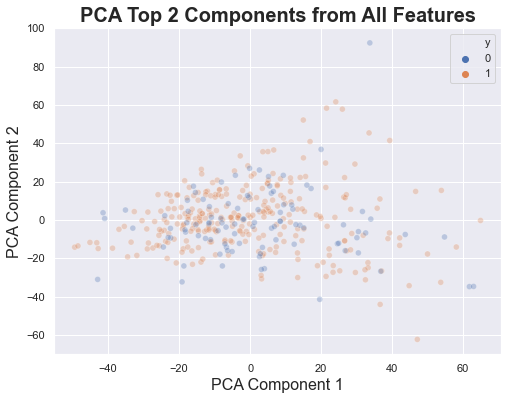

In [41]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=dataviz[0], y=dataviz[1],
    hue = 'y',
    data=dataviz,
    legend="full",
    alpha=0.3
)
    
plt.xlabel('PCA Component 1', fontsize=16)
plt.ylabel('PCA Component 2', fontsize=16)
plt.title('PCA Top 2 Components from All Features', fontsize=20, fontweight="semibold")
plt.show()

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 375 samples in 0.000s...
[t-SNE] Computed neighbors for 375 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 375 / 375
[t-SNE] Mean sigma: 8.516681
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.104958
[t-SNE] KL divergence after 300 iterations: 0.549701
t-SNE done! Time elapsed: 0.6725749969482422 seconds


<ipython-input-42-522736304989>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataviz['tsne-2d-one'] = tsne_results[:,0]
<ipython-input-42-522736304989>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataviz['tsne-2d-two'] = tsne_results[:,1]


Text(0.5, 1.0, 'tSNE from All Features')

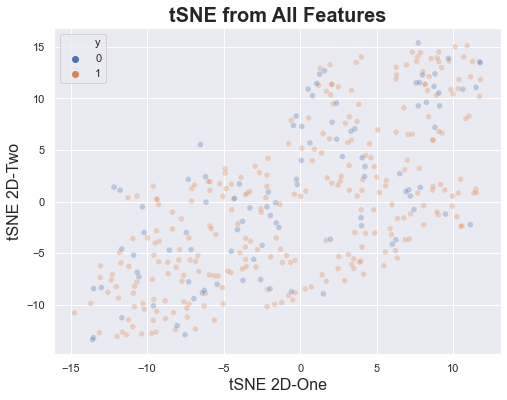

In [42]:
import time
from sklearn.manifold import TSNE

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(dataviz)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

dataviz['tsne-2d-one'] = tsne_results[:,0]
dataviz['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(8,6))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue= 'y',
    data=dataviz,
    legend="full",
    alpha=0.3
)
plt.xlabel('tSNE 2D-One', fontsize=16)
plt.ylabel('tSNE 2D-Two', fontsize=16)
plt.title('tSNE from All Features', fontsize=20, fontweight="semibold")


In [43]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(second_principaldf, second_target, 
                                                    test_size = 0.25, random_state = 42)

In [44]:
second_X = pd.concat([X_train_2, y_train_2], axis = 1)
second_X_0 = second_X[second_X['path'] == 0]
second_X_1 = second_X[second_X['path'] == 1]

In [45]:
second_upsampled_0 = resample(second_X_0, replace = True, n_samples = len(second_X_1), random_state = 42)
second_upsampled = pd.concat([second_upsampled_0, second_X_1])
second_upsampled = second_upsampled.sample(frac = 1, random_state = 42)

In [46]:
X_train_2 = second_upsampled.iloc[:, :-1]
y_train_2 = second_upsampled.iloc[:, -1]

In [47]:
lr_seq_2_model = LogisticRegression(penalty = 'l2', C = 1, max_iter = 2000, random_state = 42)

In [48]:
lr_seq_2_model.fit(X_train_2, y_train_2)
y_pred_2 = lr_seq_2_model.predict(X_test_2)

In [49]:
accuracy_score(y_test_2, y_pred_2)

0.8404255319148937

# Second Model (MB/EP) - uses new Lasso reduction

In [50]:
second_target = df["path"]

In [51]:
second_target.value_counts()

mb      278
pilo    160
ep       97
Name: path, dtype: int64

In [52]:
second_features = df.drop(['id', 'path'], axis = 1)

In [53]:
second_target = second_target.map(dict(ep = 0, pilo = -1, mb = 1))
second_target = second_target[second_target != -1]
second_features = second_features.iloc[second_target.index]

In [54]:
second_target.value_counts()

1    278
0     97
Name: path, dtype: int64

In [55]:
second_target = second_target.reset_index(drop = True)
second_features = second_features.reset_index(drop = True)

In [56]:
second_reduced_features_list = reduced_features.loc[reduced_features['MB/EP_2ndstage'].isnull() == False, ['MB/EP_2ndstage']].values.tolist()

In [57]:
second_reduced_features_list = [item for sublist in second_reduced_features_list for item in sublist]

In [58]:
second_features = second_features[second_reduced_features_list]

In [59]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(second_features, second_target, 
                                                    test_size = 0.25, random_state = 42)

In [60]:
second_X = pd.concat([X_train_2, y_train_2], axis = 1)
second_X_0 = second_X[second_X['path'] == 0]
second_X_1 = second_X[second_X['path'] == 1]

In [61]:
second_upsampled_0 = resample(second_X_0, replace = True, n_samples = len(second_X_1), random_state = 42)
second_upsampled = pd.concat([second_upsampled_0, second_X_1])
second_upsampled = second_upsampled.sample(frac = 1, random_state = 42)

In [62]:
X_train_2 = second_upsampled.iloc[:, :-1]
y_train_2 = second_upsampled.iloc[:, -1]

In [63]:
second_names = X_train_2.columns
second_scaler = preprocessing.StandardScaler()

In [64]:
X_train_2 = second_scaler.fit_transform(X_train_2)
X_train_2 = pd.DataFrame(X_train_2, columns = second_names)

In [65]:
X_test_2 = second_scaler.transform(X_test_2)
X_test_2 = pd.DataFrame(X_test_2, columns = second_names)

In [66]:
nn_seq_2_model = MLPClassifier(hidden_layer_sizes = (50, 100, 50), learning_rate = 'constant', 
                         max_iter = 2000, random_state = 42)

In [67]:
nn_seq_2_model.fit(X_train_2, y_train_2)
y_pred_2 = nn_seq_2_model.predict(X_test_2)

In [68]:
accuracy_score(y_test_2, y_pred_2)

0.8723404255319149

In [69]:
print("Accuracy Score: " + str(accuracy_score(y_test_2, y_pred_2)))
print("Specificity Score: " + str(specificity_score(y_test_2.to_numpy(), y_pred_2)))
print("Precision: " + str(precision_score(y_test_2, y_pred_2)))
print("Recall: " + str(recall_score(y_test_2, y_pred_2)))
print("F1 Score: " + str(f1_score(y_test_2, y_pred_2)))

print("PPV Score: " + str(positive_pv_score(y_test_2.to_numpy(), y_pred_2)))
print("NPV Score: " + str(negative_pv_score(y_test_2.to_numpy(), y_pred_2)))

Accuracy Score: 0.8723404255319149
Specificity Score: 0.7
Precision: 0.918918918918919
Recall: 0.918918918918919
F1 Score: 0.918918918918919
PPV Score: 0.918918918918919
NPV Score: 0.7


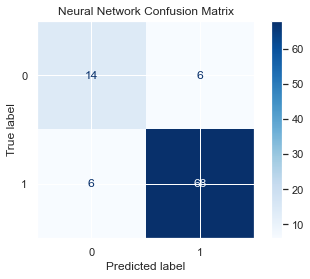

In [70]:
matrix = plot_confusion_matrix(nn_seq_2_model, X_test_2, y_test_2,
                               cmap=plt.cm.Blues)
plt.title('Neural Network Confusion Matrix')
plt.show(matrix)
plt.show()

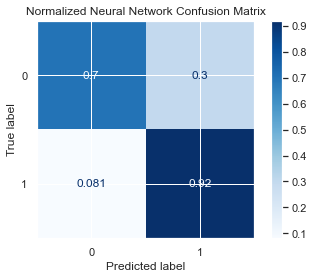

In [71]:
matrix = plot_confusion_matrix(nn_seq_2_model, X_test_2, y_test_2,
                               cmap=plt.cm.Blues,
                               normalize = 'true')
plt.title('Normalized Neural Network Confusion Matrix')
plt.show(matrix)
plt.show()

# Testing

In [72]:
test_features = df.drop(['id', 'path'], axis = 1) 
test_target = df["path"]

In [73]:
#mapping_dict = {0: 'ep', 1: 'pilo', 2: 'mb'}
test_target = test_target.map(dict(ep = 0, pilo = 1, mb = 2))

In [74]:
X_train, X_test, y_train, y_test = train_test_split(test_features, test_target, 
                                                    test_size = 0.25, random_state = 42)

In [75]:
X_test = X_test.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

In [76]:
X_test_reduced = X_test[reduced_features_list]

In [77]:
names = X_test_reduced.columns
X_test_for_first = first_scaler.transform(X_test_reduced)
X_test_for_first = pd.DataFrame(X_test_for_first, columns = names)

In [78]:
y_preds_after_first = lr_seq_1_model.predict(X_test_for_first)

In [79]:
pilo_indices = np.where(y_preds_after_first == 1)
other_indices = np.where(y_preds_after_first != 1)

In [80]:
pilo_preds = y_preds_after_first[pilo_indices]
y_test_for_pilo = np.array(y_test)[pilo_indices]

In [81]:
X_test_after_first_model = X_test.iloc[other_indices].reset_index(drop = True)
y_test_after_first_model = y_test.iloc[other_indices].reset_index(drop = True)

In [82]:
X_test_after_first_model = X_test_after_first_model[second_reduced_features_list]

In [83]:
X_test_after_first_model = second_scaler.transform(X_test_after_first_model)

In [84]:
# X_test_after_first_model = second_scaler.transform(X_test_after_first_model)
# second_testprincipalComponents = second_pca.transform(X_test_after_first_model)
# X_test_after_first_model = pd.DataFrame(data = second_testprincipalComponents)

In [85]:
y_test_after_first_model = np.array(y_test_after_first_model)
y_test_after_first_model[y_test_after_first_model == 1] = -1
y_test_after_first_model[y_test_after_first_model == 2] = 1

In [86]:
y_preds_after_second = nn_seq_2_model.predict(X_test_after_first_model)

In [87]:
accuracy_score(y_test_after_first_model, y_preds_after_second)

0.9032258064516129

In [88]:
y_preds_after_second[y_preds_after_second == 1] = 2

In [89]:
y_test_after_first_model[y_test_after_first_model == 1] = 2
y_test_after_first_model[y_test_after_first_model == -1] = 1

In [90]:
y_preds_overall = np.concatenate([y_preds_after_second, pilo_preds])
y_test_overall = np.concatenate([y_test_after_first_model, y_test_for_pilo])

In [91]:
accuracy_score(y_test_overall, y_preds_overall)

0.917910447761194

In [92]:
sns.reset_orig()

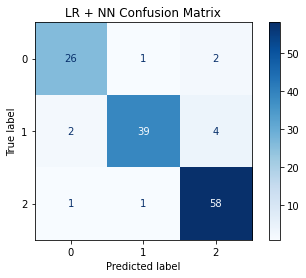

In [93]:
matrix = create_confusion_matrix(y_test_overall, y_preds_overall, cmap=plt.cm.Blues)
plt.title('LR + NN Confusion Matrix')
plt.show(matrix)
plt.show()

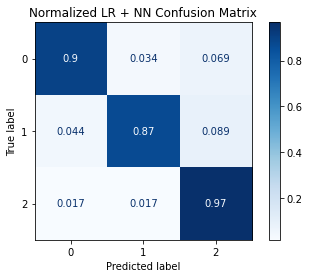

In [94]:
matrix = create_confusion_matrix(y_test_overall, y_preds_overall, cmap=plt.cm.Blues, normalize = 'true')
plt.title('Normalized LR + NN Confusion Matrix')
plt.show(matrix)
plt.show()

In [95]:
y_test_np = y_test.to_numpy()
my_classification_report(y_test_overall, y_preds_overall)

Specificities
0 0.9714285714285714
1 0.9775280898876404
2 0.918918918918919
Macro Avg : 0.9559585267450436
Micro Avg : 0.9589552238805971 

PPV/Precision
0 0.896551724137931
1 0.9512195121951219
2 0.90625
Macro Avg : 0.9180070787776843
Micro Avg : 0.917910447761194 

NPV
0 0.9714285714285714
1 0.9354838709677419
2 0.9714285714285714
Macro Avg : 0.9594470046082949
Micro Avg : 0.9589552238805971 

Recall
0 0.896551724137931
1 0.8666666666666667
2 0.9666666666666667
Macro Avg : 0.9099616858237548
Micro Avg : 0.917910447761194 

F1 Score
0 0.896551724137931
1 0.9069767441860465
2 0.9354838709677419
Macro Avg : 0.9139666773078782
Micro Avg : 0.917910447761194 

Accuracy:
0 0.9552238805970149
1 0.9402985074626866
2 0.9402985074626866
Macro Avg : 0.9452736318407959
Micro Avg : 0.945273631840796 



In [96]:
y_test_bin = label_binarize(y_test_overall, classes = [0, 1, 2])
y_pred_bin = label_binarize(y_preds_overall, classes = [0, 1, 2])

In [97]:
n_classes = 3

n_bootstraps = 2000
rng_seed = 42  # control reproducibility
bootstrapped_auc_scores = []
bootstrapped_acc_scores = []
bootstrapped_spec_scores = []
bootstrapped_prec_scores = []
bootstrapped_rec_scores = []
bootstrapped_f_one_scores = []
bootstrapped_ppv_scores = [] ##
bootstrapped_npv_scores = [] ##

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_test_overall), len(y_test_overall))
    if len(np.unique(y_test_overall[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue
    
    one_acc = []
    one_spec = []
    one_prec = []
    one_rec = []
    one_f_one = []
    one_ppv = [] ##
    one_npv = [] ##
    for i in range(n_classes):
        one_acc.append(accuracy_score(y_test_bin[:, i][indices], y_pred_bin[:, i][indices]))
        one_spec.append(specificity_score(y_test_bin[:, i][indices], y_pred_bin[:, i][indices]))
        one_prec.append(precision_score(y_test_bin[:, i][indices], y_pred_bin[:, i][indices]))
        one_rec.append(recall_score(y_test_bin[:, i][indices], y_pred_bin[:, i][indices]))
        one_f_one.append(f1_score(y_test_bin[:, i][indices], y_pred_bin[:, i][indices]))
        one_ppv.append(positive_pv_score(y_test_bin[:, i][indices], y_pred_bin[:, i][indices])) ##
        one_npv.append(negative_pv_score(y_test_bin[:, i][indices], y_pred_bin[:, i][indices])) ##

    bootstrapped_acc_scores.append(one_acc)
    bootstrapped_spec_scores.append(one_spec)
    bootstrapped_prec_scores.append(one_prec)
    bootstrapped_rec_scores.append(one_rec)
    bootstrapped_f_one_scores.append(one_f_one)
    bootstrapped_ppv_scores.append(one_ppv) ##
    bootstrapped_npv_scores.append(one_npv) ##

In [98]:
create_ci(bootstrapped_acc_scores, "Accuracy")
create_ci(bootstrapped_spec_scores, "Specificity")
create_ci(bootstrapped_prec_scores, "Precision")
create_ci(bootstrapped_rec_scores, "Recall")
create_ci(bootstrapped_f_one_scores, "F1")
create_ci(bootstrapped_ppv_scores, "PPV") ##
create_ci(bootstrapped_npv_scores, "NPV") ##

95% Confidence interval for the Accuracy score for class 0: [0.9179 - 0.9851]
95% Confidence interval for the Accuracy score for class 1: [0.8955 - 0.9776]
95% Confidence interval for the Accuracy score for class 2: [0.8955 - 0.9776]
95% Confidence interval for the Specificity score for class 0: [0.9358 - 1.0]
95% Confidence interval for the Specificity score for class 1: [0.9419 - 1.0]
95% Confidence interval for the Specificity score for class 2: [0.8472 - 0.9744]
95% Confidence interval for the Precision score for class 0: [0.7692 - 1.0]
95% Confidence interval for the Precision score for class 1: [0.8750 - 1.0]
95% Confidence interval for the Precision score for class 2: [0.8308 - 0.9701]
95% Confidence interval for the Recall score for class 0: [0.7778 - 1.0]
95% Confidence interval for the Recall score for class 1: [0.7568 - 0.9556]
95% Confidence interval for the Recall score for class 2: [0.9167 - 1.0]
95% Confidence interval for the F1 score for class 0: [0.8000 - 0.9677]
95% 

# Classification Results 

In [99]:
metadata_df = df['path']
target_for_table = df['path']

In [100]:
features_for_table = df.drop(['id', 'path'], axis = 1)
target_for_table = target_for_table.map(dict(ep = 0, pilo = 1, mb = 2))

In [101]:
#only used for metadata for which is train and which is test
X_train_for_table, X_test_for_table, _, _ = train_test_split(features_for_table, target_for_table, 
                                                    test_size = 0.25, random_state = 42)

In [102]:
X_train_for_table['Set'] = 'training'
X_test_for_table['Set'] = 'test'

<ipython-input-102-e808b9f961f0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_for_table['Set'] = 'training'
<ipython-input-102-e808b9f961f0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_for_table['Set'] = 'test'


In [103]:
X_for_table = pd.concat([X_train_for_table, X_test_for_table])
X_for_table = pd.merge(metadata_df, X_for_table, left_index = True, right_index = True)

In [104]:
final_df = X_for_table[['path', 'Set']]
features_for_table = df.drop(['id', 'path'], axis = 1)
target_for_table = X_for_table['path']
target_for_table = target_for_table.map(dict(ep = 0, pilo = 1, mb = 2))

In [105]:
X_table_reduced = features_for_table[reduced_features_list]

In [106]:
names = X_table_reduced.columns
X_table_for_first = first_scaler.transform(X_table_reduced)
X_table_for_first = pd.DataFrame(X_table_for_first, columns = names)

In [107]:
y_probs_after_first_table = lr_seq_1_model.predict_proba(X_table_for_first)

In [108]:
lr_1_table = pd.DataFrame(y_probs_after_first_table, columns = ['LR1 Non-Pilo Prob','LR1 Pilo Prob'])

In [109]:
final_df['LR1 Non-Pilo Prob'] = lr_1_table['LR1 Non-Pilo Prob']
final_df['LR1 Pilo Prob'] = lr_1_table['LR1 Pilo Prob']

<ipython-input-109-8f02735d0d28>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['LR1 Non-Pilo Prob'] = lr_1_table['LR1 Non-Pilo Prob']
<ipython-input-109-8f02735d0d28>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['LR1 Pilo Prob'] = lr_1_table['LR1 Pilo Prob']


In [110]:
final_df

,path,Set,LR1 Non-Pilo Prob,LR1 Pilo Prob
0,pilo,test,8.588772e-01,0.141123
1,pilo,training,1.477281e-07,1.000000
2,pilo,test,9.985160e-01,0.001484
3,pilo,training,7.492398e-04,0.999251
4,pilo,training,1.676286e-01,0.832371
...,...,...,...,...
530,ep,test,4.001257e-01,0.599874
531,ep,test,9.913852e-01,0.008615
532,ep,training,9.999756e-01,0.000024
533,ep,training,9.961599e-01,0.003840


In [111]:
y_preds_after_first_table = lr_seq_1_model.predict(X_table_for_first)
pilo_table_indices = np.where(y_preds_after_first_table == 1)
other_table_indices = np.where(y_preds_after_first_table != 1)

In [112]:
y_table_for_pilo = np.array(y_preds_after_first_table)[pilo_table_indices]
X_table_after_first_model = features_for_table.iloc[other_table_indices]
X_table_after_first_model = X_table_after_first_model[second_reduced_features_list]
X_table_after_first_model_arr = second_scaler.transform(X_table_after_first_model)

In [113]:
y_probs_after_second_table = nn_seq_2_model.predict_proba(X_table_after_first_model_arr)
y_preds_after_second_table = nn_seq_2_model.predict(X_table_after_first_model_arr)

In [114]:
nn_2_table = pd.DataFrame(y_probs_after_second_table, columns = ['NN2 EP Prob','NN2 MB Prob'])

In [115]:
X_table_after_first_model['NN2 EP Prob'] = np.array(nn_2_table['NN2 EP Prob'])
X_table_after_first_model['NN2 MB Prob'] = np.array(nn_2_table['NN2 MB Prob'])

In [116]:
X_table_after_first_model = X_table_after_first_model[['NN2 EP Prob', 'NN2 MB Prob']]

In [117]:
final_df = final_df.merge(X_table_after_first_model, how='left', left_index=True, right_index=True)

In [118]:
def f(row):
    if row['LR1 Non-Pilo Prob'] < row['LR1 Pilo Prob']:
        val = 'pilo'
    else:
        if row['NN2 EP Prob'] > row['NN2 MB Prob']:
            val = 'ep'
        else:
            val = 'mb'
    return val

In [119]:
final_df['id'] = df['id']

In [120]:
final_df['Pred Path'] = final_df.apply(f, axis = 1)

In [121]:
# Formatting
final_df.columns = ['True Path', 'Set', 'LR1 Non-Pilo Prob', 'LR1 Pilo Prob',
                    'NN2 EP Prob', 'NN2 MB Prob', 'Id', 'Pred Path']
cols = final_df.columns.tolist()
cols = ['Id', 'LR1 Non-Pilo Prob', 'LR1 Pilo Prob', 'NN2 EP Prob', 'NN2 MB Prob', 
        'Pred Path', 'True Path', 'Set']
final_df = final_df[cols]
final_df = final_df.round(4)

In [122]:
pd.set_option('display.max_rows', None)
final_df

,Id,LR1 Non-Pilo Prob,LR1 Pilo Prob,NN2 EP Prob,NN2 MB Prob,Pred Path,True Path,Set
0,CH_PF-PILO_M_0006,0.8589,0.1411,0.0024,0.9976,mb,pilo,test
1,CP_PF-PILO_U_0001,0.0000,1.0000,NaN,NaN,pilo,pilo,training
2,CP_PF-PILO_U_0004,0.9985,0.0015,0.0001,0.9999,mb,pilo,test
3,CP_PF-PILO_U_0005,0.0007,0.9993,NaN,NaN,pilo,pilo,training
4,CP_PF-PILO_U_0006,0.1676,0.8324,NaN,NaN,pilo,pilo,training
5,CP_PF-PILO_U_0007,0.2457,0.7543,NaN,NaN,pilo,pilo,training
6,CP_PF-PILO_U_0008,0.0023,0.9977,NaN,NaN,pilo,pilo,test
7,CP_PF-PILO_U_0009,0.0000,1.0000,NaN,NaN,pilo,pilo,training
8,CP_PF-PILO_U_0010,0.0069,0.9931,NaN,NaN,pilo,pilo,training
9,CP_PF-PILO_U_0011,0.0114,0.9886,NaN,NaN,pilo,pilo,test


In [123]:
#Sanity Check
test = final_df[final_df['Set'] == 'test']
print(np.sum(test['Pred Path'] == test['True Path']))
print(len(test))

train = final_df[final_df['Set'] == 'training']
print(np.sum(train['Pred Path'] == train['True Path']))
print(len(train))

123
134
385
401


In [124]:
# If you want to export the table to CSV
#final_df.to_csv('classification_results.csv')